In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter

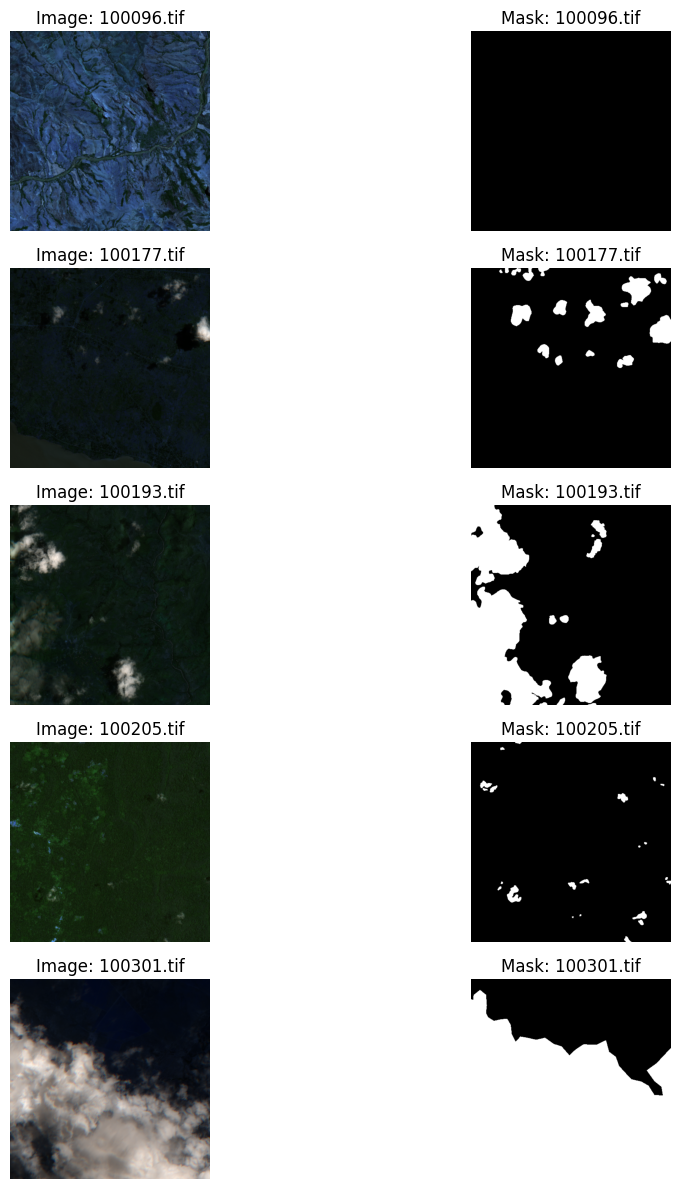

In [2]:
dataset_path = "/kaggle/input/cloud-masking-dataset/content/train"

data_dir = os.path.join(dataset_path, 'data')
mask_dir = os.path.join(dataset_path, 'masks')

# Get and sort image filenames
image_filenames = sorted([f for f in os.listdir(data_dir)])[:5]

# Display image and mask pairs
plt.figure(figsize=(12, 12))
for i, filename in enumerate(image_filenames):
    image_path = os.path.join(data_dir, filename)
    mask_path = os.path.join(mask_dir, filename)

    # Load image and mask
    image = tiff.imread(image_path)  # shape: (H, W, 4)
    mask = tiff.imread(mask_path)

    # Extract RGB channels only
    rgb_image = image[:, :, :3]

    # Normalize image if values are outside [0, 1] or [0, 255]
    if rgb_image.dtype != np.uint8:
        rgb_image = rgb_image.astype(np.float32)
        rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

    # Plot RGB image
    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(rgb_image)
    plt.title(f'Image: {filename}')
    plt.axis('off')

    # Plot corresponding mask
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(mask, cmap='gray')
    plt.title(f'Mask: {filename}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [3]:
dataset_path = "/kaggle/input/cloud-masking-dataset/content/train"
data_dir = os.path.join(dataset_path, 'data')
mask_dir = os.path.join(dataset_path, 'masks')
image_filenames = sorted([f for f in os.listdir(data_dir)])

train_filenames, val_filenames = train_test_split(
    image_filenames, 
    test_size=0.2, 
    random_state=42
)

print(f"Total images: {len(image_filenames)}")
print(f"Training set: {len(train_filenames)}")
print(f"Validation set: {len(val_filenames)}")

Total images: 10573
Training set: 8458
Validation set: 2115


In [4]:
train_images=[]
train_masks=[]
for i, filename in enumerate(train_filenames[:800]):
    image_path = os.path.join(data_dir, filename)
    mask_path = os.path.join(mask_dir, filename)
    image = tiff.imread(image_path)
    mask = tiff.imread(mask_path)
    train_images.append(image)
    train_masks.append(mask)
    
train_images=np.asarray(train_images)
train_masks=np.asarray(train_masks)
print(f"Training set: {train_images.shape} images")

Training set: (800, 512, 512, 4) images


In [5]:
val_images=[]
val_masks=[]
for i, filename in enumerate(val_filenames[:200]):
    image_path = os.path.join(data_dir, filename)
    mask_path = os.path.join(mask_dir, filename)
    image = tiff.imread(image_path)
    mask = tiff.imread(mask_path)
    val_images.append(image)
    val_masks.append(mask)
val_images=np.asarray(val_images)
val_masks=np.asarray(val_masks)
print(f"Validation set: {val_images.shape} images")

Validation set: (200, 512, 512, 4) images


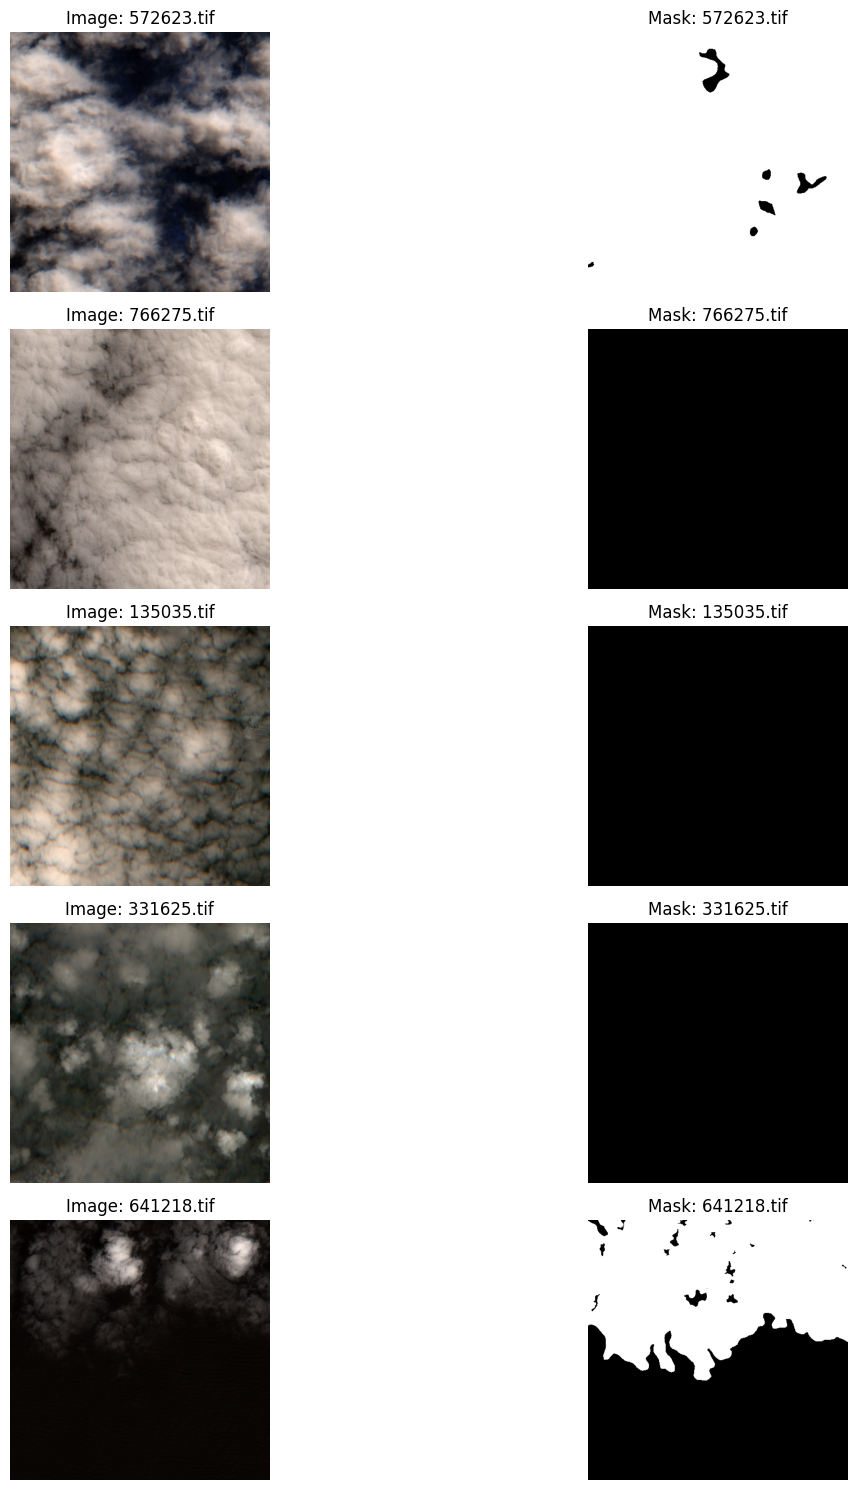

In [16]:
plt.figure(figsize=(15, 15))
for i, filename in enumerate(val_filenames[10:15]):
    image_path = os.path.join(data_dir, filename)
    mask_path = os.path.join(mask_dir, filename)

    # Load image and mask
    image = tiff.imread(image_path)  # shape: (H, W, 4)
    mask = tiff.imread(mask_path)

    # Extract RGB channels only
    rgb_image = image[:, :, :3]

    # Normalize image if values are outside [0, 1] or [0, 255]
    if rgb_image.dtype != np.uint8:
        rgb_image = rgb_image.astype(np.float32)
        rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

    # Plot RGB image
    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(rgb_image)
    plt.title(f'Image: {filename}')
    plt.axis('off')

    # Plot corresponding mask
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(mask, cmap='gray')
    plt.title(f'Mask: {filename}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [7]:
# def compute_class_priors(mask_dir, filenames):
#     no_cloud_count = 0
#     cloud_count = 0
    
#     for filename in filenames:
#         mask = tiff.imread(os.path.join(mask_dir, filename))
#         cloud_pixels = np.sum(mask == 1)
#         no_cloud_pixels = np.sum(mask == 0)
        
#         cloud_count += cloud_pixels
#         no_cloud_count += no_cloud_pixels
    
#     total_pixels = cloud_count + no_cloud_count
#     p_no_cloud = no_cloud_count / total_pixels
#     p_cloud = cloud_count / total_pixels
    
#     return p_no_cloud, p_cloud

# prior_no_cloud, prior_cloud = compute_class_priors(mask_dir, train_filenames)
# print(f"P(No Cloud): {prior_no_cloud:.4f}")
# print(f"P(Cloud): {prior_cloud:.4f}")
prior_cloud = 0.6211

In [8]:
def compute_histogram_4d(images,masks,class_value,bins = 20,smooth_sigma = 0.9):
    #[N_pixels, 4] images [N_pixels] masks
    pixels = images.reshape(-1, 4)  
    mask_flat = masks.reshape(-1) 
    class_pixels = pixels[mask_flat == class_value]
    ranges=[]
    for i in range(4):
        ranges.append((class_pixels[:,i].min(),class_pixels[:,i].max()))
    hist, edges = np.histogramdd(class_pixels, bins=bins, range=ranges)
    if smooth_sigma > 0:
        hist = gaussian_filter(hist, sigma=smooth_sigma)
    hist = hist / hist.sum()
    return hist, edges


hist_cloud, edges = compute_histogram_4d(train_images,train_masks,1)
hist_noncloud, edges = compute_histogram_4d(train_images,train_masks,0)


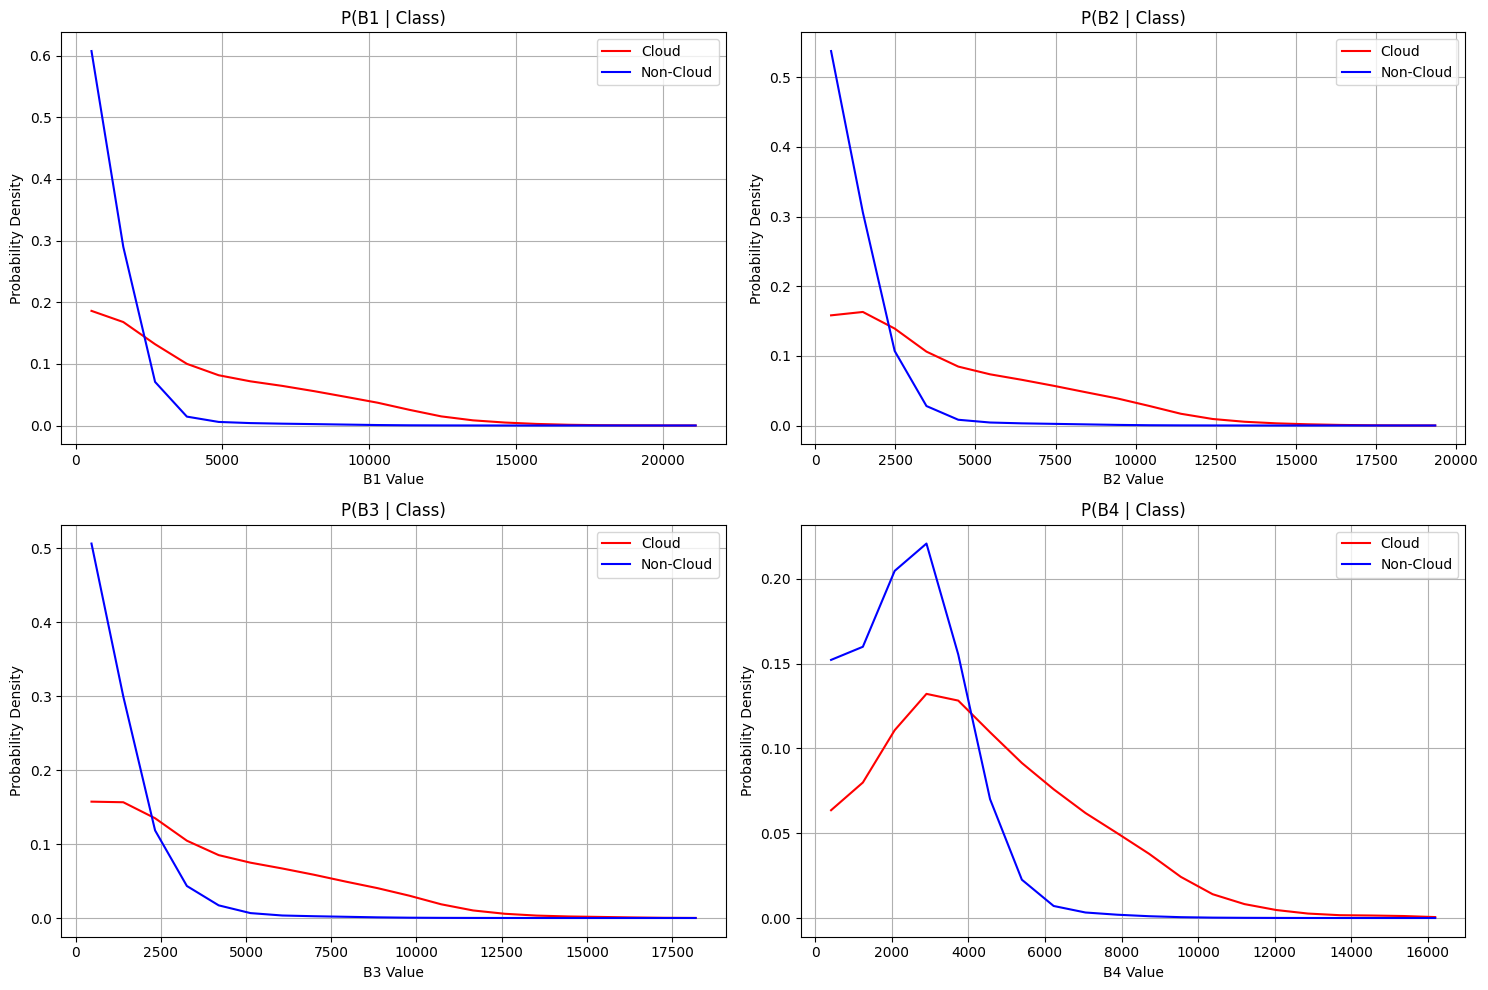

In [9]:
def compute_all_conditional_probs(hist, edges):
    probs = []
    centers = []
    for dim in range(4):  # For each band (B1-B4)
        prob = np.sum(hist, axis=tuple(d for d in range(4) if d != dim))
        band_edges = edges[dim]
        band_centers = (band_edges[:-1] + band_edges[1:]) / 2
        probs.append(prob)
        centers.append(band_centers)
    return probs, centers


p_cloud, centers = compute_all_conditional_probs(hist_cloud, edges)
p_noncloud, _ = compute_all_conditional_probs(hist_noncloud, edges)
band_names = ['B1', 'B2', 'B3', 'B4']
plt.figure(figsize=(15, 10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(centers[i], p_cloud[i], 'r-', label='Cloud')
    plt.plot(centers[i], p_noncloud[i], 'b-', label='Non-Cloud')
    plt.xlabel(f'{band_names[i]} Value')
    plt.ylabel('Probability Density')
    plt.title(f'P({band_names[i]} | Class)')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [10]:
def bayesian_classifier(image, p_cloud, p_noncloud, centers, prior_cloud):
    H, W, _ = image.shape
    classification = np.zeros((H, W), dtype=np.uint8)
    probability = np.zeros((H, W))
    
    bin_indices = []
    for dim in range(4):
        # Find which bin each pixel falls into
        indices = np.digitize(image[:,:,dim], centers[dim]) - 1
        # Clip to valid range
        indices = np.clip(indices, 0, len(p_cloud[dim])-1)
        bin_indices.append(indices)
    
    for i in range(H):
        for j in range(W):
            # Get likelihoods for all bands
            like_cloud = 1.0
            like_noncloud = 1.0
            for dim in range(4):
                b = bin_indices[dim][i,j]
                like_cloud *= p_cloud[dim][b]
                like_noncloud *= p_noncloud[dim][b]
            posterior = (like_cloud * prior_cloud) / (like_cloud * prior_cloud + like_noncloud * (1 - prior_cloud))
            
            probability[i,j] = posterior
            classification[i,j] = 1 if posterior > 0.5 else 0
    
    return classification, probability


In [11]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten().astype(float)
    y_pred_f = y_pred.flatten().astype(float)
    
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice


Evaluating validation image 1/5
Dice Coefficient: 0.8652 for image: 0


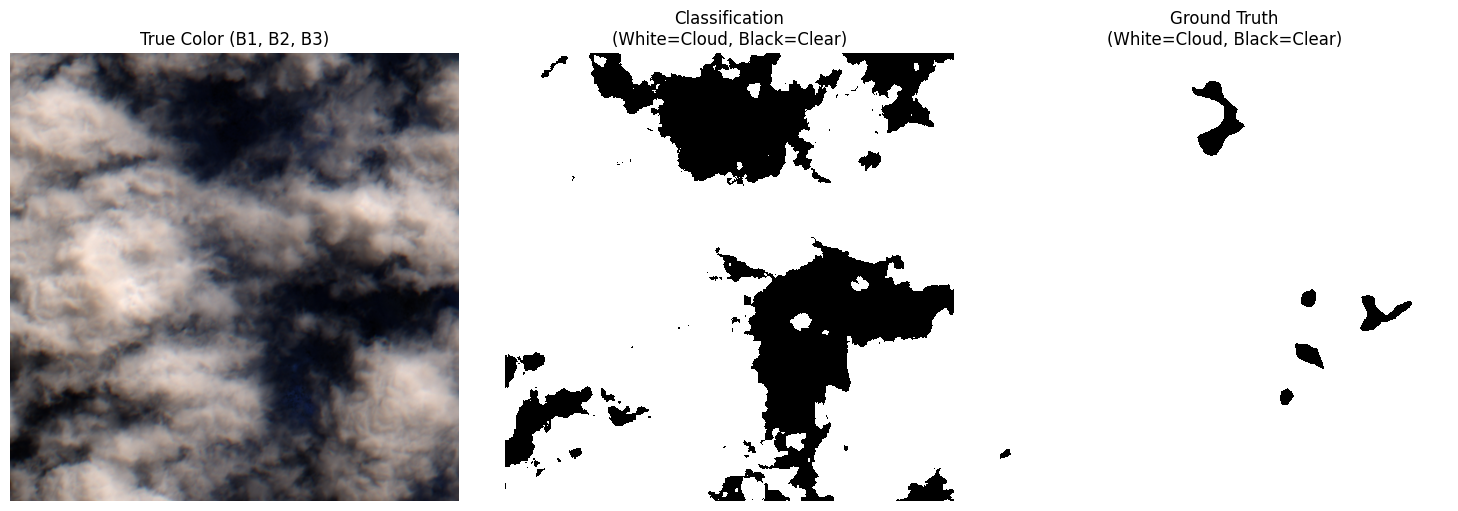


Evaluating validation image 2/5
Dice Coefficient: 0.9989 for image: 1


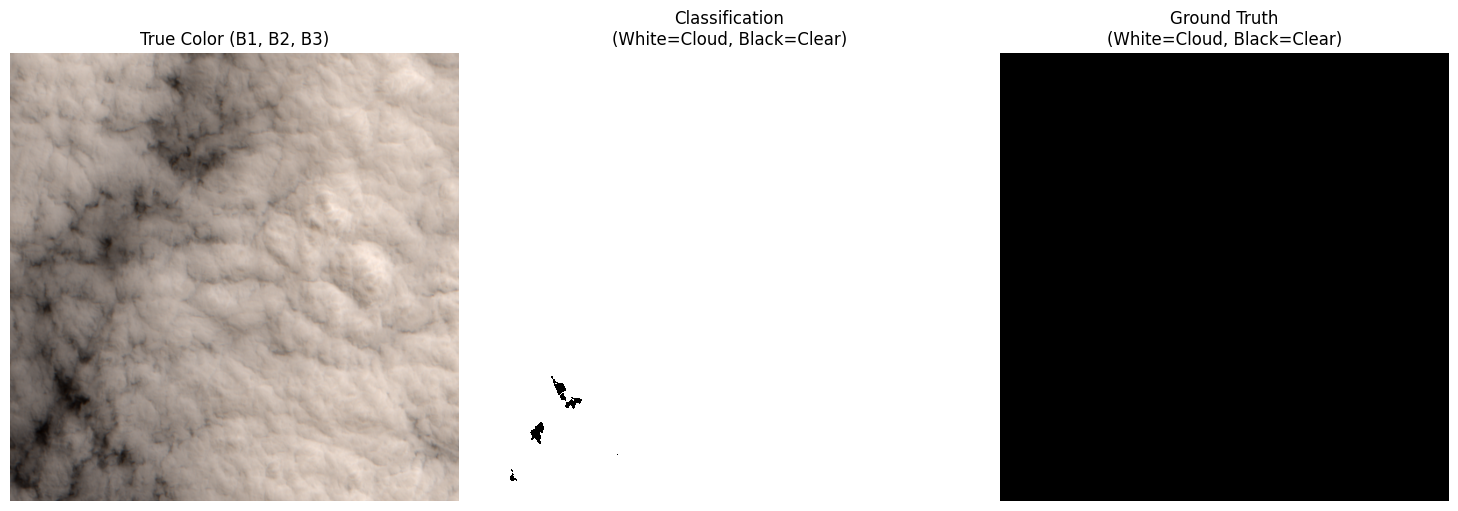


Evaluating validation image 3/5
Dice Coefficient: 0.8923 for image: 2


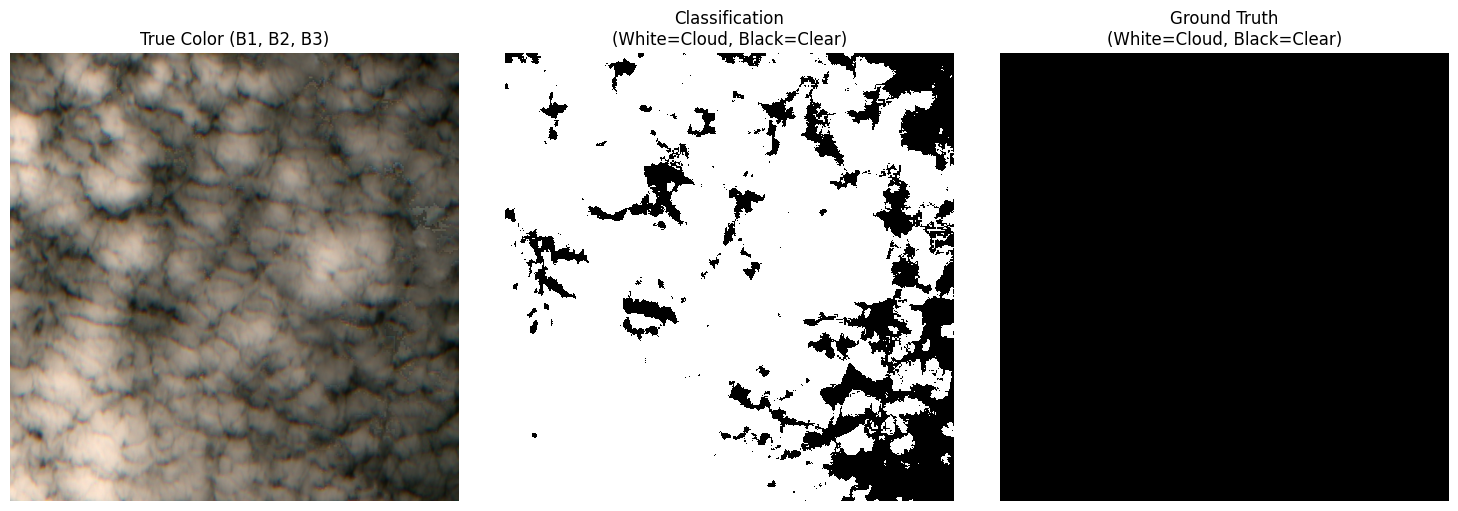


Evaluating validation image 4/5
Dice Coefficient: 0.5947 for image: 3


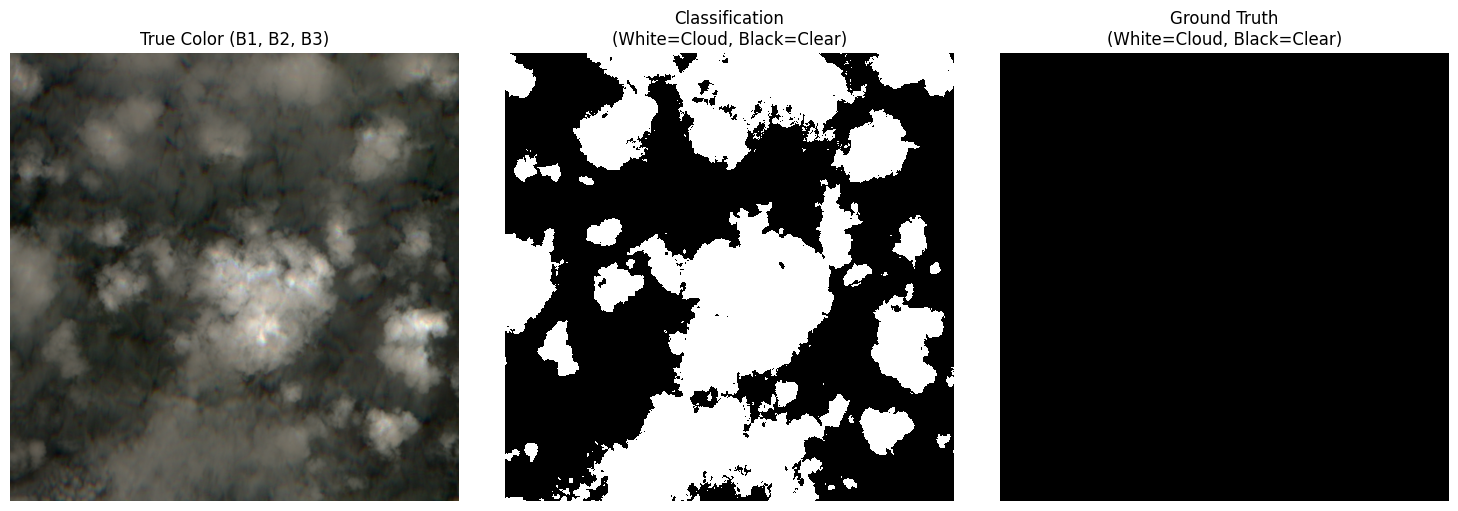


Evaluating validation image 5/5
Dice Coefficient: 0.2499 for image: 4


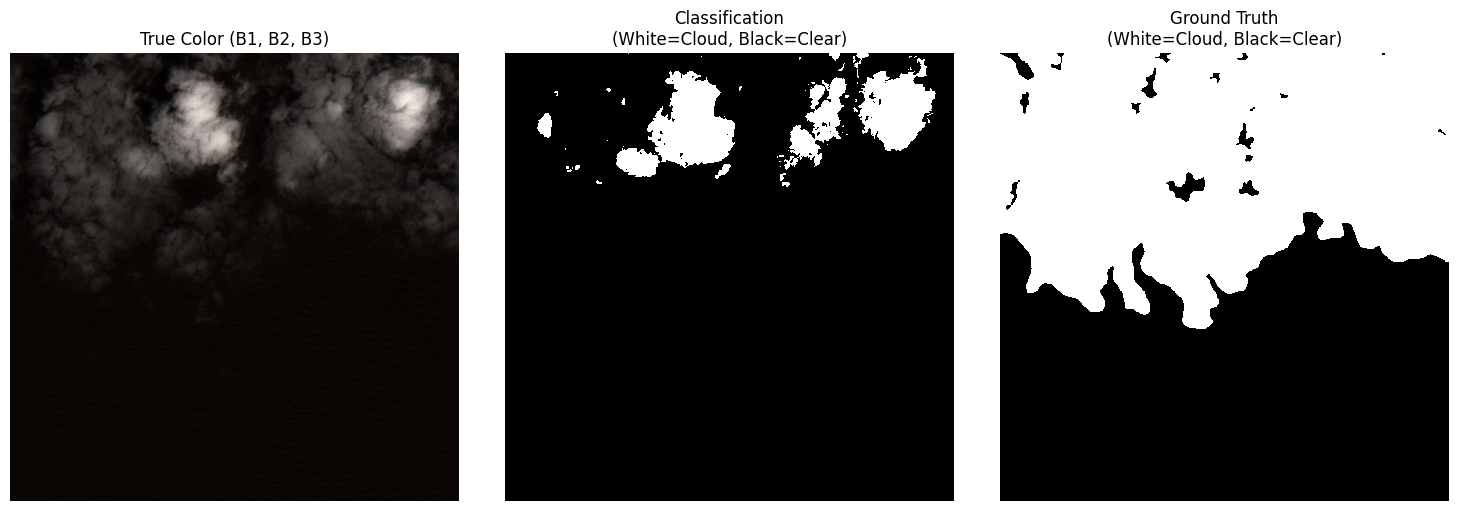

In [17]:
def visualize_results(test_image, test_mask, classification_map, prob_map=None):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    rgb_image = test_image[:, :, :3]
    if rgb_image.dtype != np.uint8:
        rgb_image = rgb_image.astype(np.float32)
        rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())
    
    plt.imshow(rgb_image)
    plt.title('True Color (B1, B2, B3)')
    plt.axis('off')

    # 2. Classification Result
    plt.subplot(1, 3, 2)
    plt.imshow(classification_map, cmap='gray', interpolation='nearest')
    plt.title('Classification\n(White=Cloud, Black=Clear)')
    plt.axis('off')

    # 3. Ground Truth Mask
    plt.subplot(1, 3, 3)
    plt.imshow(test_mask, cmap='gray', interpolation='nearest')
    plt.title('Ground Truth\n(White=Cloud, Black=Clear)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def visualize_validation_set(val_images, val_masks,classifier_args):
    for i, (img, mask) in enumerate(zip(val_images, val_masks)):
        print(f"\nEvaluating validation image {i+1}/{len(val_images)}")
        classification_map, prob_map = bayesian_classifier(img, **classifier_args)
        dice = dice_coefficient(mask, classification_map)
        print(f"Dice Coefficient: {dice:.4f} for image: {i}")
        visualize_results(img, mask, classification_map, prob_map)

classifier_args = {
    'p_cloud': p_cloud,
    'p_noncloud': p_noncloud,
    'centers': centers,
    'prior_cloud': prior_cloud
}

visualize_validation_set(val_images[10:15], val_masks[10:15], classifier_args)

# x = 8  # Example index
# test_image = val_images[x]
# test_mask = val_masks[x]
# classification_map, prob_map = bayesian_classifier(test_image, **classifier_args)
# visualize_results(test_image, test_mask, classification_map, prob_map)

In [ ]:
def evaluate_validation_set(val_images, val_masks, classifier_args):
    dice_scores = []
    
    for i, (img, mask) in enumerate(zip(val_images, val_masks)):
        print(f"\nEvaluating validation image {i+1}/{len(val_images)}")
        classification_map, _ = bayesian_classifier(img, **classifier_args)
        dice = dice_coefficient(mask, classification_map)
        dice_scores.append(dice)
        print(f"Dice Coefficient: {dice:.4f} for image: {i}")
    
    print("\n=== Evaluation Summary ===")
    print(f"Mean Dice: {np.mean(dice_scores):.4f}")
    print(f"Std Dice: {np.std(dice_scores):.4f}")
    print(f"Min Dice: {np.min(dice_scores):.4f}")
    print(f"Max Dice: {np.max(dice_scores):.4f}")
    return dice_scores
dice_scores = evaluate_validation_set(val_images, val_masks,classifier_args)